In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

C:\Users\emirhan\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\emirhan\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
df = pd.read_csv("churn.csv")

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
df.drop("RowNumber",
        axis = 1 ,
        inplace = True)

In [7]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Preprocessing

In [8]:
df["Gender"].replace({"Female":0,"Male":1},inplace = True)

In [9]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


In [10]:
def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []

    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)

        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]

            print(col, ":", number_of_outliers)
            variable_names.append(col)

            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()

    return variable_names

In [11]:
num_cols = [col for col in df.columns if df[col].dtypes != "O" and col not in "CustomerId"]

CreditScore : 15


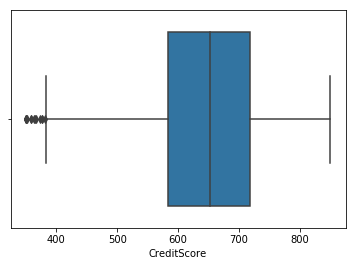

Age : 359


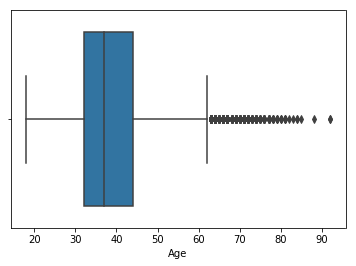

NumOfProducts : 60


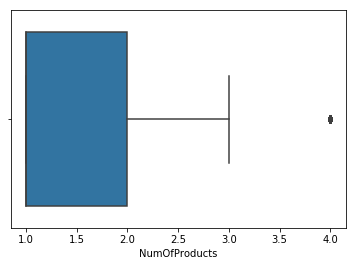

Exited : 2037


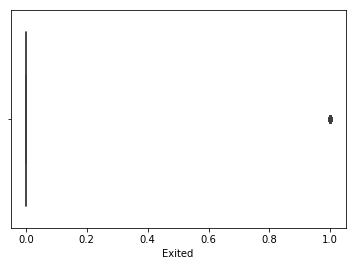

['CreditScore', 'Age', 'NumOfProducts', 'Exited']

In [12]:
has_outliers(df,num_cols,plot = True)

'CreditScore', 'Age', 'NumOfProducts' isimli değişkenlerimizde aykırı gözlemlerimiz bulunmaktadır. Exited Target değişken olduğu için onu görmezden geliyoruz.

In [13]:
df.loc[(df["Age"]>=18) & (df["Age"]<=30), "Age"]=1
df.loc[(df["Age"]>30) & (df["Age"]<=40), "Age"]=2
df.loc[(df["Age"]>40) & (df["Age"]<=50), "Age"]=3
df.loc[(df["Age"]>50) & (df["Age"]<=60), "Age"]=4
df.loc[(df["Age"]>60) & (df["Age"]<=92), "Age"]=5

In [14]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,0,3,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,0,3,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,0,3,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,0,2,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,0,3,2,125510.82,1,1,1,79084.10,0


In [15]:
df1=pd.get_dummies(df,columns=["Geography"], drop_first=True)
df1.head()

,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,15634602,Hargrave,619,0,3,2,0.00,1,1,1,101348.88,1,0,0
1,15647311,Hill,608,0,3,1,83807.86,1,0,1,112542.58,0,0,1
2,15619304,Onio,502,0,3,8,159660.80,3,1,0,113931.57,1,0,0
3,15701354,Boni,699,0,2,1,0.00,2,0,0,93826.63,0,0,0
4,15737888,Mitchell,850,0,3,2,125510.82,1,1,1,79084.10,0,0,1


In [16]:
df1["retired"]=df["Age"]

df1.loc[(df1["retired"]>=65) & (df1["Geography_Germany"]==1), "retired"]=1
df1.loc[(df1["retired"]>=65) & (df1["Geography_Spain"]==1), "retired"]=1
df1.loc[(df1["retired"]>=66) & (df1["Geography_Spain"]==0) & (df1["Geography_Germany"]==0), "retired"]=1


df1.loc[(df1["retired"]<65) & (df1["Geography_Germany"]==1), "retired"]=0
df1.loc[(df1["retired"]<65) & (df1["Geography_Spain"]==1), "retired"]=0
df1.loc[(df1["retired"]<66) & (df1["Geography_Spain"]==0) & (df1["Geography_Germany"]==0), "retired"]=0

In [17]:
df1.head()

,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,retired
0,15634602,Hargrave,619,0,3,2,0.00,1,1,1,101348.88,1,0,0,0
1,15647311,Hill,608,0,3,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15619304,Onio,502,0,3,8,159660.80,3,1,0,113931.57,1,0,0,0
3,15701354,Boni,699,0,2,1,0.00,2,0,0,93826.63,0,0,0,0
4,15737888,Mitchell,850,0,3,2,125510.82,1,1,1,79084.10,0,0,1,0


In [18]:
df1.drop(["CustomerId","Surname"],axis = 1,
         inplace = True)

In [19]:
df1['BalanceSalaryRatio'] = df1.Balance/df1.EstimatedSalary
df1['CreditScoreGivenAge'] = df1.CreditScore*df1.Age

In [20]:
#!pip install SomeFunctions

In [21]:
df1.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,retired,BalanceSalaryRatio,CreditScoreGivenAge
0,619,0,3,2,0.00,1,1,1,101348.88,1,0,0,0,0.000000,1857
1,608,0,3,1,83807.86,1,0,1,112542.58,0,0,1,0,0.744677,1824
2,502,0,3,8,159660.80,3,1,0,113931.57,1,0,0,0,1.401375,1506
3,699,0,2,1,0.00,2,0,0,93826.63,0,0,0,0,0.000000,1398
4,850,0,3,2,125510.82,1,1,1,79084.10,0,0,1,0,1.587055,2550


In [22]:
num_list = df1[["Balance","CreditScoreGivenAge","EstimatedSalary","CreditScore"]]

In [24]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(num_list)
normalized=transformer.transform(num_list)

In [25]:
df_norm = pd.DataFrame(normalized)

In [26]:
df_norm.columns = num_list.columns

In [27]:
df3 = df1.drop(num_list,axis = 1)

In [28]:
df3.head()

,Gender,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Geography_Germany,Geography_Spain,retired,BalanceSalaryRatio
0,0,3,2,1,1,1,1,0,0,0,0.000000
1,0,3,1,1,0,1,0,0,1,0,0.744677
2,0,3,8,3,1,0,1,0,0,0,1.401375
3,0,2,1,2,0,0,0,0,0,0,0.000000
4,0,3,2,1,1,1,0,0,1,0,1.587055


In [29]:
df2 = pd.concat([df3,df_norm],axis = 1)

In [30]:
df2.head()

,Gender,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Geography_Germany,Geography_Spain,retired,BalanceSalaryRatio,Balance,CreditScoreGivenAge,EstimatedSalary,CreditScore
0,0,3,2,1,1,1,1,0,0,0,0.000000,0.000000,0.018319,0.999814,0.006106
1,0,3,1,1,0,1,0,0,1,0,0.744677,0.597208,0.012998,0.801969,0.004333
2,0,3,8,3,1,0,1,0,0,0,1.401375,0.813976,0.007678,0.580841,0.002559
3,0,2,1,2,0,0,0,0,0,0,0.000000,0.000000,0.014898,0.999861,0.007449
4,0,3,2,1,1,1,0,0,1,0,1.587055,0.845915,0.017186,0.533009,0.005729


In [31]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
Gender                 10000 non-null int64
Age                    10000 non-null int64
Tenure                 10000 non-null int64
NumOfProducts          10000 non-null int64
HasCrCard              10000 non-null int64
IsActiveMember         10000 non-null int64
Exited                 10000 non-null int64
Geography_Germany      10000 non-null uint8
Geography_Spain        10000 non-null uint8
retired                10000 non-null int64
BalanceSalaryRatio     10000 non-null float64
Balance                10000 non-null float64
CreditScoreGivenAge    10000 non-null float64
EstimatedSalary        10000 non-null float64
CreditScore            10000 non-null float64
dtypes: float64(5), int64(8), uint8(2)
memory usage: 1.0 MB


# LogisticReg

In [32]:
y = df2["Exited"]
X = df2.drop(["Exited"], axis = 1)

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20,random_state = 42)
log_rec = LogisticRegression().fit(X_train,y_train)
y_pred = log_rec.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.821


In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1607
           1       0.62      0.22      0.33       393

    accuracy                           0.82      2000
   macro avg       0.73      0.60      0.61      2000
weighted avg       0.79      0.82      0.79      2000



# LGBM

LGBM accuracy: 0.851 

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1585
           1       0.73      0.44      0.55       415

    accuracy                           0.85      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



Text(0.5, 1.0, 'LightGBM Model')

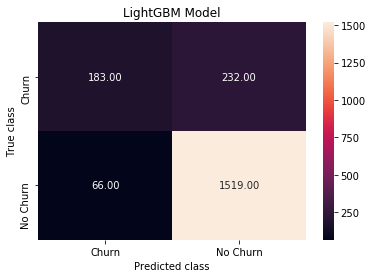

In [35]:
y = df2["Exited"]
X = df2.drop(["Exited"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123456)
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
print('LGBM accuracy: {:.3f}'.format(accuracy_score(y_test, lgbm.predict(X_test))), '\n')
print(classification_report(y_test, lgbm.predict(X_test)))
lgbm_y_pred = lgbm.predict(X_test)
lgbm_cm = confusion_matrix( y_test,lgbm_y_pred, [1,0])
sns.heatmap(lgbm_cm, annot=True, fmt='.2f',xticklabels = ["Churn", "No Churn"] , yticklabels = ["Churn", "No Churn"] )
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('LightGBM Model')

In [44]:
(len(df[df["Exited"] == 1]["Exited"]) / len(df["Exited"])) * 100

20.369999999999997

In [45]:
(len(df[df["Exited"] == 0]["Exited"]) / len(df["Exited"])) * 100

79.63

- LightGBM modelimiz lojistik regresyon modelimize göre daha iyi sonuç vermiş bulunmakta.
- Lightgbmde herhangi bir model tuning işlemi gerçekleştirilmemiştir. 
- Confusion matrix'imize göre model churn olmayan müşterileri daha iyi tahmin etmiştir.
- Veri setimizde dengesizlik mevcuttur. Churn olma durumu tüm veri setinin %20.36sını kapsarken, Churn olmayanlar %79.63ü oluşturmaktadır.